In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from time import time

In [2]:
df_ncc = pd.read_csv("./ncc.binetflow")
df_ncc=df_ncc[~df_ncc['Label'].str.contains("Background", case=False, na=False)]
df_ncc = df_ncc.sample(25000)
df_iot = pd.read_csv("./iot23.csv").sample(25000)
df_ctu = pd.read_csv("./ctu.csv").sample(25000)
df_ctu=df_ctu[~df_ctu['Label'].str.contains("Background", case=False, na=False)]
df_ctu = df_ctu.sample(25000)

C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\157375421.py:1: DtypeWarning: Columns (1,9,10,11,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ncc = pd.read_csv("./ncc.binetflow")
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\157375421.py:4: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iot = pd.read_csv("./iot23.csv").sample(25000)
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\157375421.py:5: DtypeWarning: Columns (5,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ctu = pd.read_csv("./ctu.csv").sample(25000)


In [3]:
df_iot['ActivityLabel'] = df_iot['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df_iot = df_iot.drop(columns=['label'])
df_ctu['ActivityLabel'] = df_ctu['BOTNET'].apply(lambda x: 0 if x == 0 else 1)
df_ctu = df_ctu.drop(columns=['BOTNET'])

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def plot_traffic_graph(df, src_col, dst_col, activity_col):
    df= df.head(5000)
    # Create the directed graph
    G = nx.Graph()
    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row[src_col], row[dst_col], activity=row['ActivityLabel'])

    # Define node colors based on the ActivityLabel
    node_colors = []
    for node in G.nodes:
        if node in df[src_col].values:
            activity = df[df[src_col] == node]['ActivityLabel'].values[0]
        elif node in df[dst_col].values:
            activity = df[df[dst_col] == node]['ActivityLabel'].values[0]
        else:
            activity = 0  # Default to normal if no activity is found

        if activity == 1:
            node_colors.append('red')  # Botnet node
        else:
            node_colors.append('blue')  # Normal node

    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(G, node_color=node_colors, with_labels=False, node_size=50)
    plt.title('Network Traffic with Botnet (Red) and Normal (Blue) Nodes')
    plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df,src_col="SrcAddr",dst_col="DstAddr"):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == src_col or column == dst_col:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps

def feature_selection_vif(dataset, srcLabel, dstLabel, alpha=0.005, vif_threshold=20):
    # Load and clean the dataset
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()

    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df,srcLabel,dstLabel)

    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)

    # Compute Composite Node Importance (CNI)
    cni_scores = {}
    for node in G.nodes():
        cni_scores[node] = (degree_centrality_norm.get(node, 0) +
                            closeness_centrality_norm.get(node, 0) +
                            betweenness_centrality_norm.get(node, 0)) / 3

    # Calculate additional graph metrics
    in_degree, out_degree, eigenvector_centrality, betweenness_centrality = calculate_additional_graph_metrics(G)

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()
    dataset_with_metrics['orig_h_CNI'] = dataset_with_metrics[srcLabel].map(cni_scores)
    dataset_with_metrics['resp_h_CNI'] = dataset_with_metrics[dstLabel].map(cni_scores)
    dataset_with_metrics['average_CNI'] = dataset_with_metrics[['orig_h_CNI', 'resp_h_CNI']].mean(axis=1)

    ip_cni_map = {ip: cni_scores[ip] for ip in cni_scores if ip in dataset_with_metrics[srcLabel].unique() or ip in dataset_with_metrics[dstLabel].unique()}
    df_final = dataset_with_metrics

    # Normalize the features
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

    # Calculate traditional VIF
    def calculate_vif(df):
        df = df.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        X = df.values
        vif_scores = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        vif_data = pd.DataFrame({'Feature': df.columns, 'Traditional_VIF': vif_scores})
        return vif_data

    
    start_time_1 = time()
    vif_results = calculate_vif(df_normalized)
    vif_time = time() - start_time_1
    vif_scores = vif_results

    # Iterative VIF-based feature selection
    features_to_remove = []
    high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()
    while high_vif_features:
        feature_to_remove = high_vif_features[0]
        features_to_remove.append(feature_to_remove)
        vif_results = vif_results[vif_results['Feature'] != feature_to_remove]
        remaining_features = vif_results['Feature'].tolist()
        X_subset = df_normalized[remaining_features]
        vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
        high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()

    # Calculate Modified VIF
    def calculate_modified_vif(X, alpha):
        X = X.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        
        features = X.columns
        mvif_data = []
        for feature in features:
            predictors = [feat for feat in features if feat != feature]
            model = LinearRegression().fit(X[predictors], X[feature])
            r_squared = model.score(X[predictors], X[feature])
            average_cni_mean = dataset_with_metrics['average_CNI'].mean()
            # Normalizing the adjustment term
            normalized_adjustment = (r_squared + alpha * average_cni_mean) / (1 + alpha * average_cni_mean)
        
        # Ensure the value inside the division is positive
            if normalized_adjustment >= 1.0:
                normalized_adjustment = 1.0 - 1e-6  # Adjust to avoid negative or zero denominator

            modified_vif = 1 / (1 - normalized_adjustment)
            mvif_data.append({'Feature': feature, 'Modified_VIF': modified_vif})
        
        return pd.DataFrame(mvif_data)

    X = df_normalized
    start_time_1 = time()
    mvif_results = calculate_modified_vif(X, alpha)
    mvif_time = time() - start_time_1

    final_vif_results = pd.merge(vif_scores, mvif_results, on='Feature')
    selected_features = mvif_results[mvif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()
    selected_features_vif = vif_results[vif_results['Traditional_VIF'] < vif_threshold]['Feature'].tolist()

    return df_final, final_vif_results,mvif_time,vif_time,selected_features,selected_features_vif,maps


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical

def create_ffnn(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    
    if input_shape[0] >= 4:
        model.add(MaxPooling1D(2))
        new_shape = input_shape[0] // 2
        if new_shape >= 5:
            model.add(Conv1D(64, 3, activation='relu'))
            if new_shape - 2 >= 2:
                model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_models(features, df, label_col='ActivityLabel'):
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Ensemble (Voting)': VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(solver='liblinear')),
                ('rf', RandomForestClassifier()),
                ('svm', SVC(probability=True))
            ], voting='soft'
        )
    }
    
    results = {}
    
    X = df[features]
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    for model_name, model in models.items():
        start_time = time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        computation_time = time() - start_time
        
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Computation Time': computation_time,
            "Model":model
        }
    
    start_time = time()
    ffnn = create_ffnn(X_train.shape[1])
    ffnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred_ffnn = (ffnn.predict(X_test) > 0.5).astype(int).flatten()
    accuracy_ffnn = accuracy_score(y_test, y_pred_ffnn)
    precision_ffnn = precision_score(y_test, y_pred_ffnn)
    recall_ffnn = recall_score(y_test, y_pred_ffnn)
    f1_ffnn = f1_score(y_test, y_pred_ffnn)
    computation_time_ffnn = time() - start_time
    
    results['FFNN'] = {
        'Accuracy': accuracy_ffnn,
        'Precision': precision_ffnn,
        'Recall': recall_ffnn,
        'F1-Score': f1_ffnn,
        'Computation Time': computation_time_ffnn,
        "Model":ffnn
    }
    
    start_time = time()
    X_train_cnn = np.expand_dims(X_train, axis=2)
    X_test_cnn = np.expand_dims(X_test, axis=2)
    input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
    cnn = create_cnn(input_shape)
    cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
    accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
    precision_cnn = precision_score(y_test, y_pred_cnn)
    recall_cnn = recall_score(y_test, y_pred_cnn)
    f1_cnn = f1_score(y_test, y_pred_cnn)
    computation_time_cnn = time() - start_time
    
    results['CNN'] = {
        'Accuracy': accuracy_cnn,
        'Precision': precision_cnn,
        'Recall': recall_cnn,
        'F1-Score': f1_cnn,
        'Computation Time': computation_time_cnn,
        "Model":cnn
    }
    
    return results

In [7]:
def plot_results(results, title):
    plot_data = []
    for model_name, result in results.items():
        plot_data.append({
            'Model': model_name,
            'Accuracy': result['Accuracy'],
            'Precision': result['Precision'],
            'Recall': result['Recall'],
            'F1-Score': result['F1-Score'],
            'Computation Time': result['Computation Time']
        })
    plot_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Accuracy', data=plot_df, palette='viridis')
    plt.title(f'Model Accuracy for {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Precision', data=plot_df, palette='viridis')
    plt.title(f'Model Precision for {title}')
    plt.ylabel('Precision')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Recall', data=plot_df, palette='viridis')
    plt.title(f'Model Recall for {title}')
    plt.ylabel('Recall')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='F1-Score', data=plot_df, palette='viridis')
    plt.title(f'Model F1-Score for {title}')
    plt.ylabel('F1-Score')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Computation Time', data=plot_df, palette='viridis')
    plt.title(f'Model Computation Time for {title}')
    plt.ylabel('Computation Time (seconds)')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_botnet_graph(df_final, selected_features_mvif, results, maps, model_name='Logistic Regression', src_col='SrcAddr', dst_col='DstAddr'):
    # Load the model
    best_model = results["SVM"]["Model"]

    # Predict labels
    X = df_final[selected_features_mvif]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y_pred = best_model.predict(X)
    df_final['Predicted_Label'] = y_pred
  
    # Filter for botnet nodes
    botnet_df = df_final[df_final['Predicted_Label'] == 1]

    # Reverse mappings
    reverse_mapping = {k: v for k, v in maps[src_col].items()}
    reverse_mapping_dst = {k: v for k, v in maps[dst_col].items()}

    # Apply mappings, handle cases where mapping might not exist
    botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
    botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')
    # Create and plot the botnet graph
    G = nx.Graph()

    # Add nodes and edges
    for index, row in botnet_df.iterrows():
        if row[src_col] != 'Unknown' and row[dst_col] != 'Unknown':
            G.add_edge(row[src_col], row[dst_col])

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    nx.draw(G, pos, with_labels=True, node_size=50, node_color='r', edge_color='b', alpha=0.5)
    plt.title('Botnet Nodes Graph')
    plt.show()



In [9]:
def process_and_plot(df, src_col, dst_col, activity_col, model_name='Logistic Regression'):
    # Plot traffic graph
    plot_traffic_graph(df, src_col, dst_col, activity_col)

    # Perform feature selection
    df_final, final_vif_results, mvif_time, vif_time, selected_features_mvif, selected_features_vif, maps = feature_selection_vif(df, src_col, dst_col)

    # Evaluate models
    results = evaluate_models(selected_features_vif, df_final)
    print(results)
    # Plot results
    plot_results(results, "VIF")

#     # Plot botnet graph
    plot_botnet_graph(df_final, selected_features_vif, results, maps, model_name,src_col,dst_col)


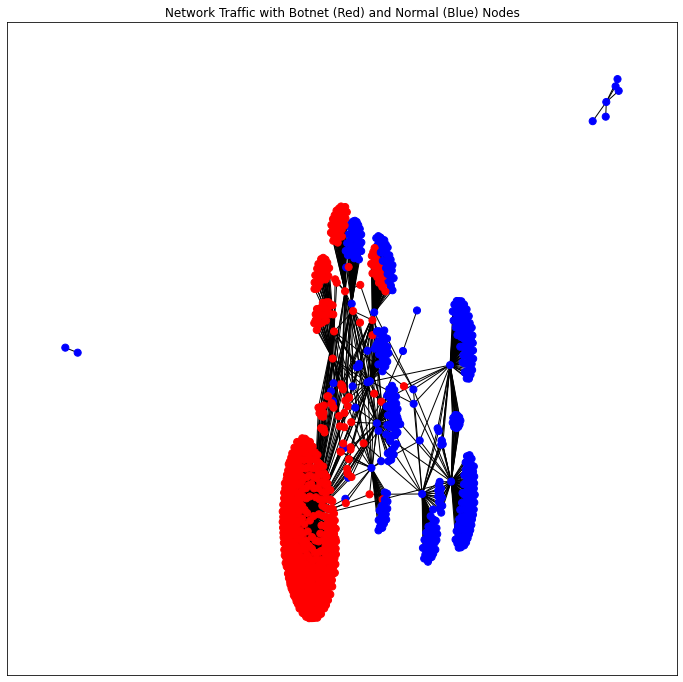

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\2008112828.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

97/97 [==============================] - 1s 3ms/step
{'Logistic Regression': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 0.05702924728393555, 'Model': LogisticRegression(solver='liblinear')}, 'Random Forest': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 1.0929765701293945, 'Model': RandomForestClassifier()}, 'SVM': {'Accuracy': 0.999029440310579, 'Precision': 0.9990224828934506, 'Recall': 0.998046875, 'F1-Score': 0.9985344406448461, 'Computation Time': 1.7687044143676758, 'Model': SVC(probability=True)}, 'Ensemble (Voting)': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 2.979912757873535, 'Model': VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')}, 'FFNN': {'Accuracy': 0.9996764

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


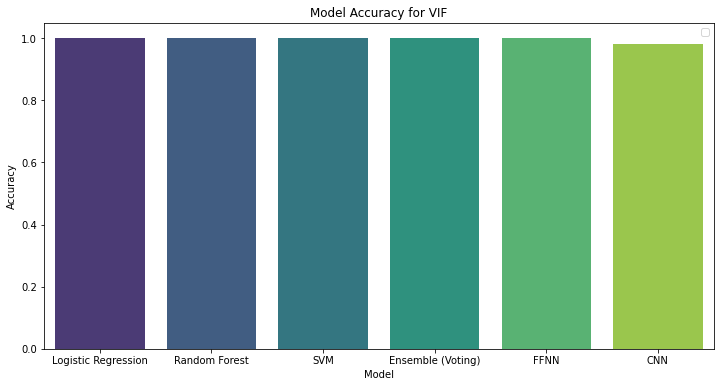

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


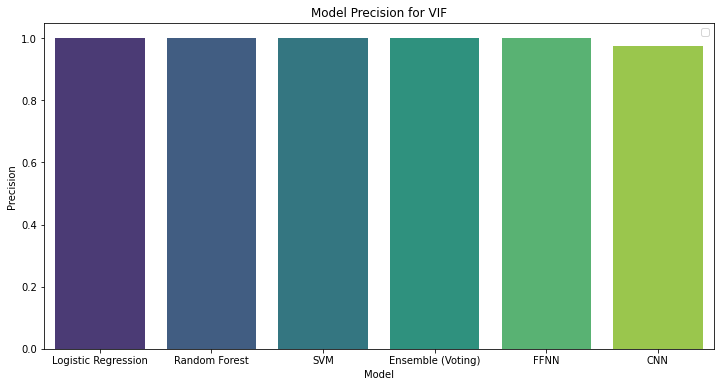

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


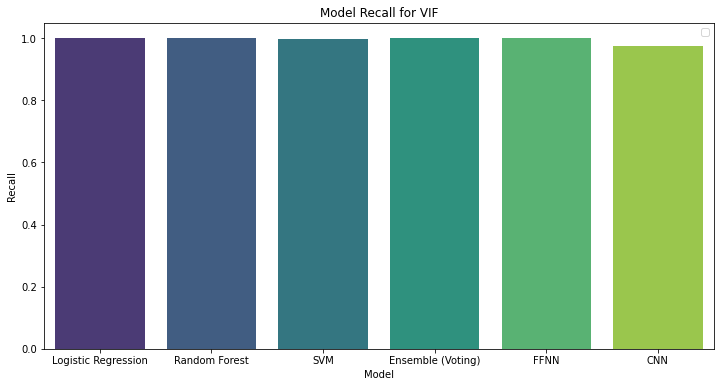

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


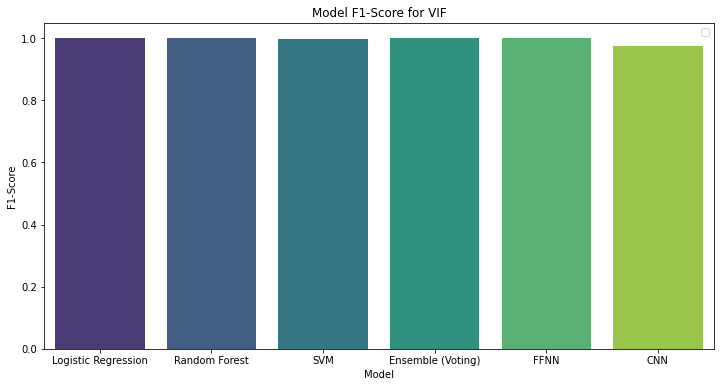

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


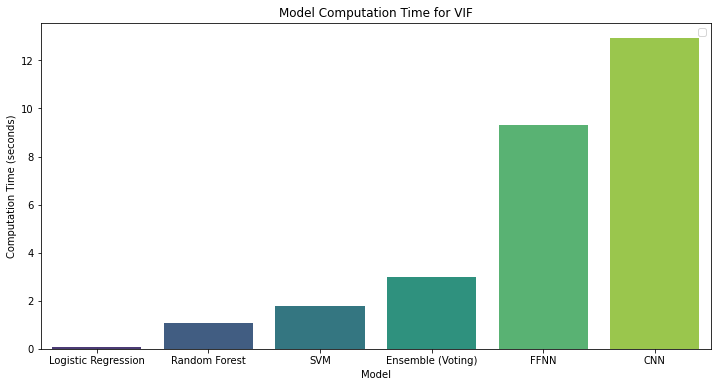

C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\1853058921.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\1853058921.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')


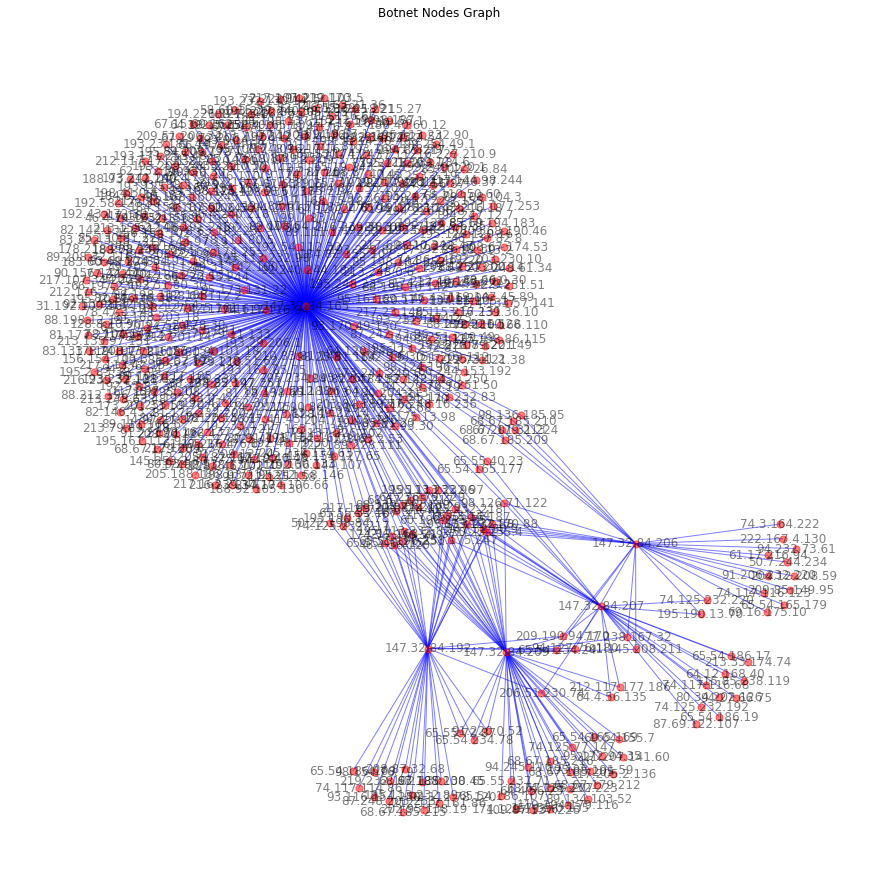

In [10]:
process_and_plot(df_ctu,"SrcAddr","DstAddr","ActivityLabel")

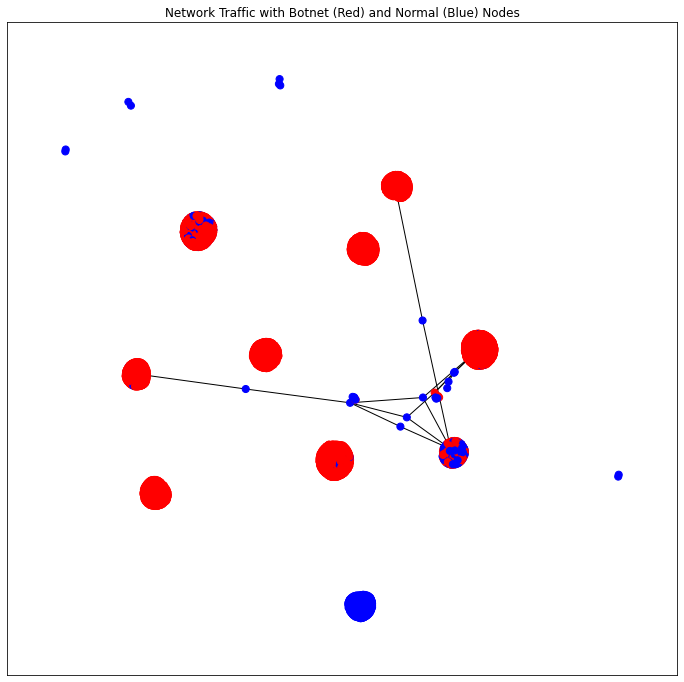

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\2008112828.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\r

235/235 [==============================] - 1s 2ms/step
{'Logistic Regression': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 0.08595871925354004, 'Model': LogisticRegression(solver='liblinear')}, 'Random Forest': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 1.208024263381958, 'Model': RandomForestClassifier()}, 'SVM': {'Accuracy': 0.9996, 'Precision': 1.0, 'Recall': 0.9995378927911276, 'F1-Score': 0.9997688929974579, 'Computation Time': 2.263559579849243, 'Model': SVC(probability=True)}, 'Ensemble (Voting)': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 3.4361629486083984, 'Model': VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')}, 'FFNN': {'Accuracy': 0.9998666666666667, 'Precis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


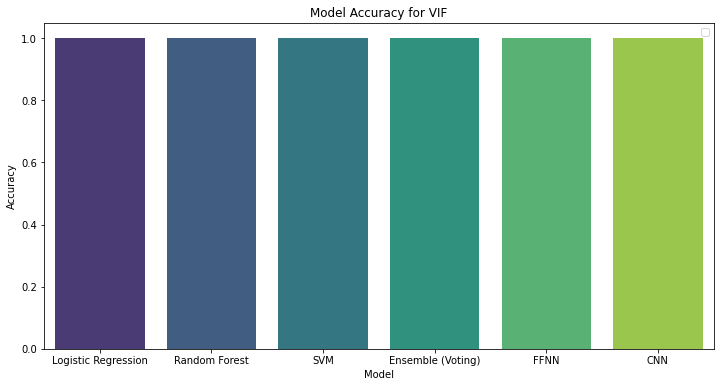

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


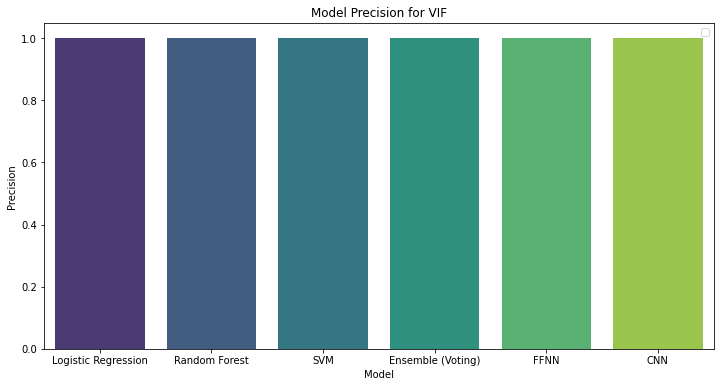

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


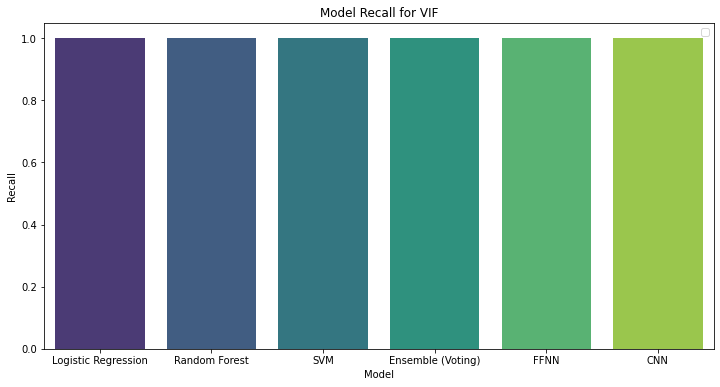

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


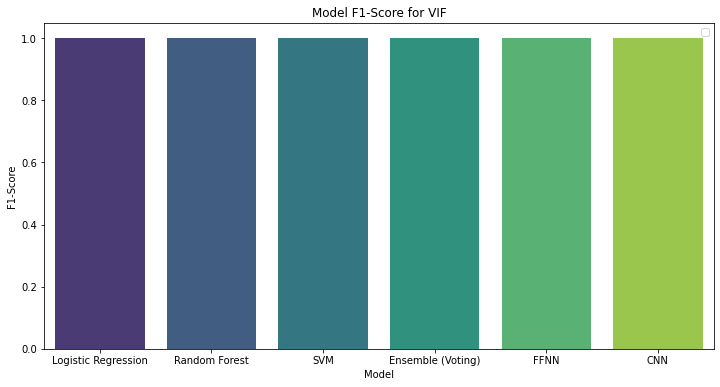

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


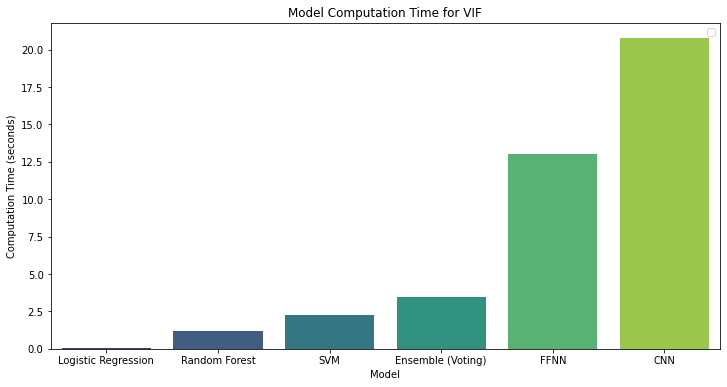

C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\1853058921.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\1853058921.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')


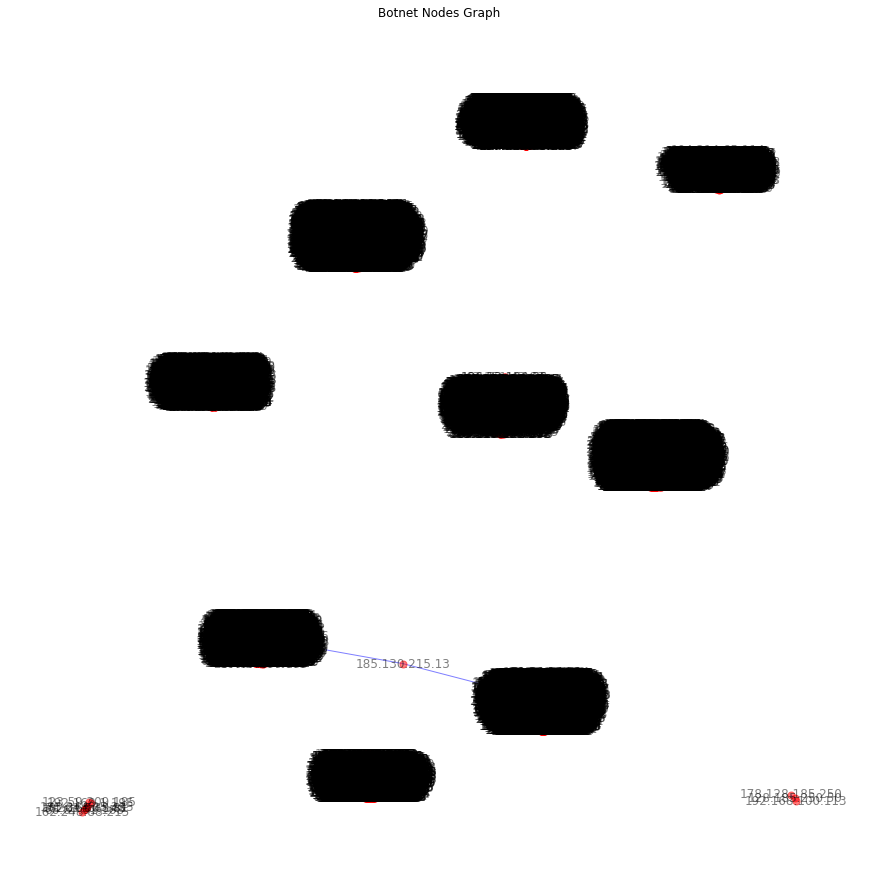

In [13]:
process_and_plot(df_iot,"id.orig_h","id.resp_h","ActivityLabel")

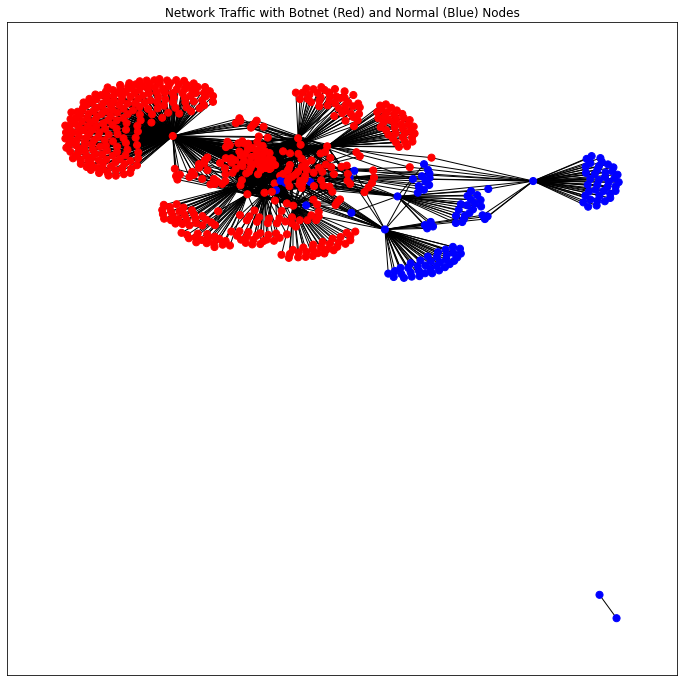

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\2008112828.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\r

202/202 [==============================] - 1s 3ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'Logistic Regression': {'Accuracy': 0.9998447927983859, 'Precision': 1.0, 'Recall': 0.9998005982053838, 'F1-Score': 0.9999002891614318, 'Computation Time': 0.1028900146484375, 'Model': LogisticRegression(solver='liblinear')}, 'Random Forest': {'Accuracy': 0.9998447927983859, 'Precision': 1.0, 'Recall': 0.9998005982053838, 'F1-Score': 0.9999002891614318, 'Computation Time': 1.8090109825134277, 'Model': RandomForestClassifier()}, 'SVM': {'Accuracy': 0.9996895855967717, 'Precision': 0.9998005982053838, 'Recall': 0.9998005982053838, 'F1-Score': 0.9998005982053838, 'Computation Time': 5.359001874923706, 'Model': SVC(probability=True)}, 'Ensemble (Voting)': {'Accuracy': 0.9998447927983859, 'Precision': 1.0, 'Recall': 0.9998005982053838, 'F1-Score': 0.9999002891614318, 'Computation Time': 7.6232171058654785, 'Model': VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier()),
                             ('svm', 

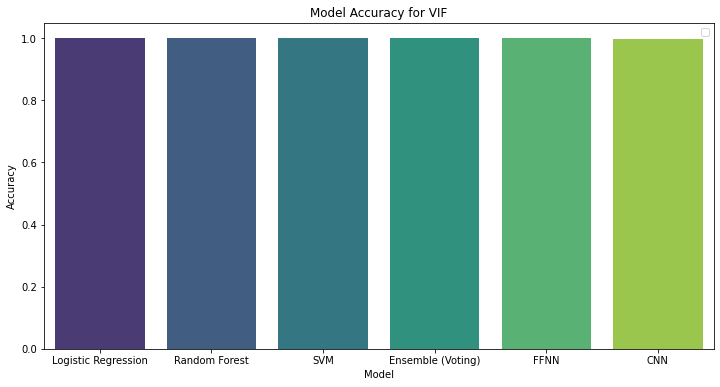

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


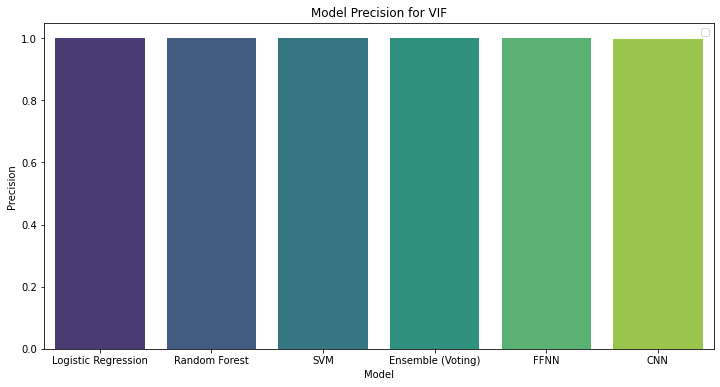

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


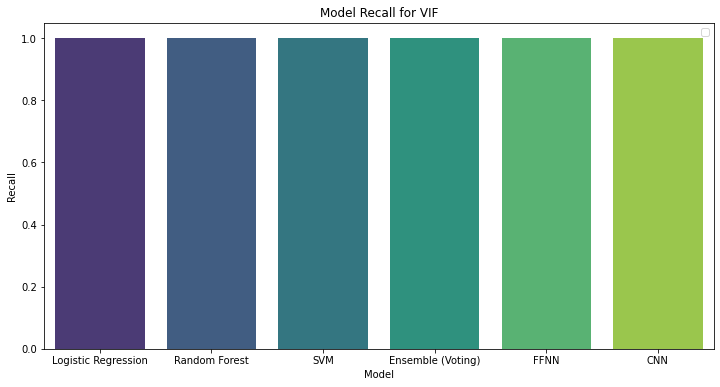

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


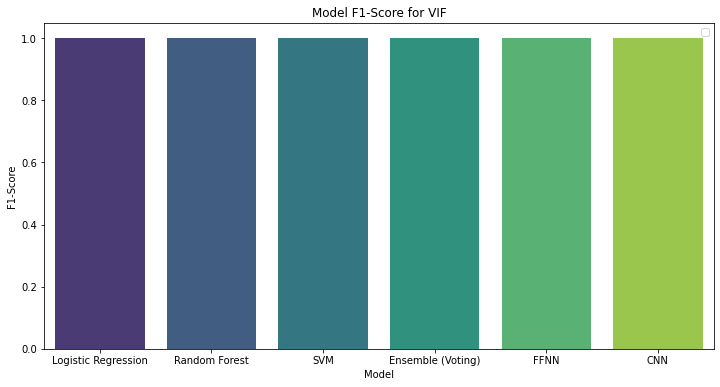

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


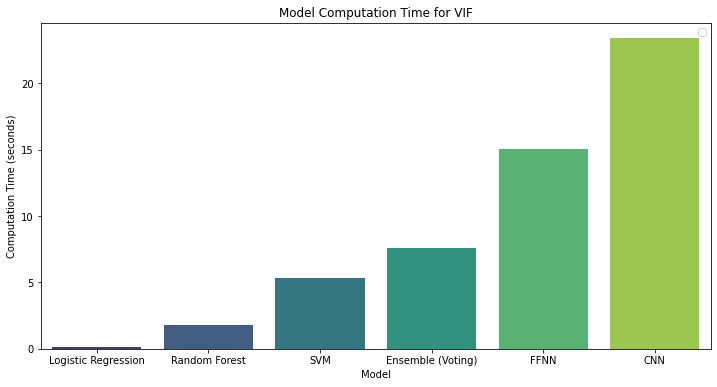

C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\1853058921.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_18036\1853058921.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')


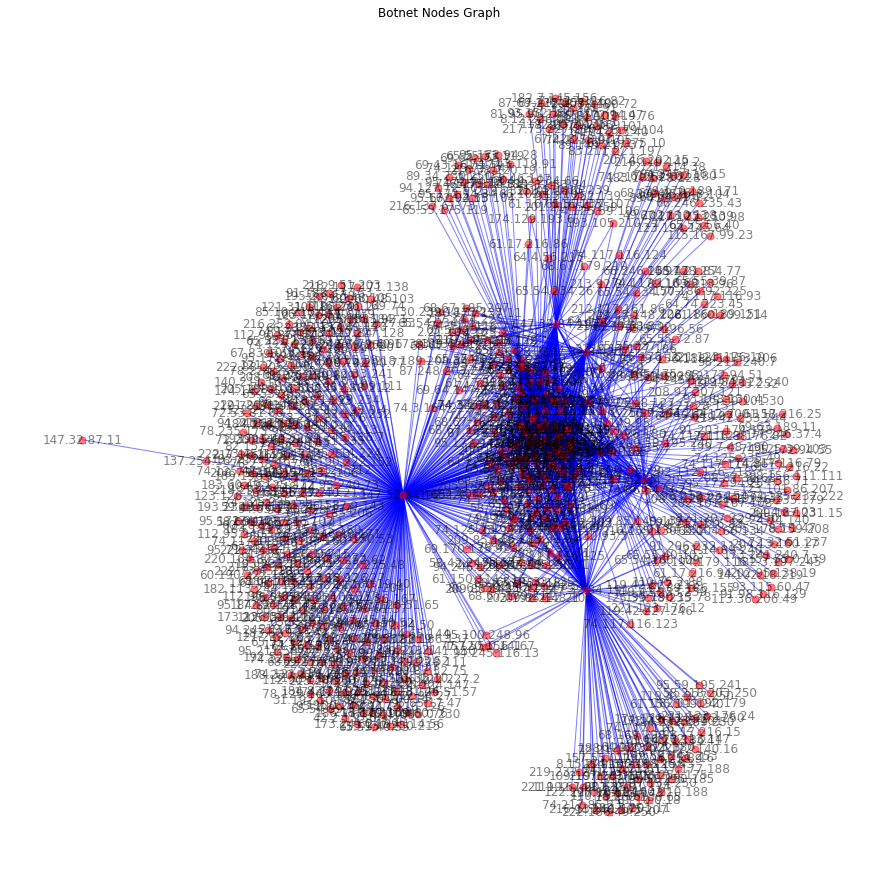

In [11]:
process_and_plot(df_ncc,"SrcAddr","DstAddr","ActivityLabel")